<h1 align='center' style='color:#e56b6f'>Interactive Globe with Plotly</h1>

<h2 style='color:#b56576'>Importing Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import plotly.graph_objs as go
from plotly.offline import plot

from netCDF4 import Dataset

import warnings
warnings.filterwarnings('ignore')

<h2 style='color:#b56576'>Download & Import Topography Data</h2>

In [2]:
def Etopo(lon_area, lat_area, resolution):
    ### Input
    # Resolution: resolution of topography for both Longitude & latitude 
    # (Original resolution is 0.0167 deg)
    # lon_area and lat_area: the region of map which you want e.g. [100, 130], [20, 25]
    ###
    ### Output
    # Mesh type longitude, latitude, and topography data
    ###
    
    # Read netCDF4 Data
    data = Dataset('ETOPO1_Ice_g_gdal.grd', 'r') # Dataset Link:(https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gdal.grd.gz)
    
    #Get Data
    lon_range = data.variables['x_range'][:]
    lat_range = data.variables['y_range'][:]
    topo_range = data.variables['z_range'][:]
    
    spacing = data.variables['spacing'][:]
    dimension = data.variables['dimension'][:]
    z = data.variables['z'][:]

    lon_num = dimension[0]
    lat_num = dimension[1]
    
    
    #Prepare Array
    lon_input = np.zeros(lon_num)
    lat_input = np.zeros(lat_num)

    for i in range(lon_num):
        lon_input[i] = lon_range[0] + i * spacing[0]

    for i in range(lat_num):
        lat_input[i] = lat_range[0] + i * spacing[1]
        
    # Create 2D Array
    lon, lat =np.meshgrid(lon_input, lat_input)
    
    #Convert 2D Array from 1D Array for z value
    topo = np.reshape(z,(lat_num, lon_num))
    
    #Skip the Data for resolution
    if ((resolution < spacing[0]) | (resolution < spacing[1])):
        print('Set the highest resolution')
    else:
        skip = int(resolution/spacing[0])
        lon = lon[::skip, ::skip]
        lat = lat[::skip,::skip]
        topo = topo[::skip, ::skip]

    topo = topo[::-1]
    
    #Select the range of map
    range1 = np.where((lon>=lon_area[0]) & (lon<=lon_area[1]))
    lon = lon[range1]
    lat = lat[range1]
    topo = topo[range1]
    
    range2 = np.where((lat>=lat_area[0])& (lat<= lat_area[1]))
    lon = lon[range2]
    lat = lat[range2]
    topo = topo[range2]
    
    
    #Convert 2D Again
    lon_num = len(np.unique(lon))
    lat_num = len(np.unique(lat))
    lon = np.reshape(lon, (lat_num, lon_num))
    lat = np.reshape(lat, (lat_num, lon_num))
    topo = np.reshape(topo, (lat_num, lon_num))
    
    return lon, lat, topo

<h2 style='color:#b56576'>Converting to the spherical coordinates

In [3]:
def degree2radians(degree):
    #Convert degrees to radians
    return degree*np.pi/180

In [4]:
def mapping_map_to_sphere(lon, lat, radius=1):
    #this function maps the points of coords(lon, lat) to points onto the sphere of radius `radius`
    lon=np.array(lon, dtype=np.float64)
    lat=np.array(lat, dtype=np.float64)
    lon=degree2radians(lon)
    lat=degree2radians(lat)
    
    xs=radius*np.cos(lon)*np.cos(lat)
    ys=radius*np.sin(lon)*np.cos(lat)
    zs=radius*np.sin(lat)
    
    return xs, ys, zs

<h2 style='color:#b56576'>Plot the Interactive Globe using Plotly

In [5]:
#Import topography Data
#Select the area you want

resolution = 0.8
lon_area = [-180., 180.]
lat_area = [-90., 90.]

#Get mesh-shape topography data

lon_topo, lat_topo, topo = Etopo(lon_area, lat_area, resolution)

#Converting to the spherical coordinates using the created function
xs, ys, zs = mapping_map_to_sphere(lon_topo, lat_topo)

In [6]:
#Defining Color Scale
Ctopo = [[0, 'rgb(0, 0, 70)'], [0.2, 'rgb(0, 90, 150)'],
        [0.4, 'rgb(150, 180, 230)'], [0.5, 'rgb(210, 230, 250)'],
         [0.50001, 'rgb(0, 120, 0)'], [0.57, 'rgb(220, 180, 130)'],
         [0.65, 'rgb(120, 100, 0)'], [0.75, 'rgb(80, 70, 0)'],
         [0.9, 'rgb(200, 200, 200)'], [1.0, 'rgb(255, 255, 255)']]

cmin = -8000
cmax = 8000
topo_sphere= dict(type='surface', 
                 x=xs,
                 y=ys,
                 z=zs,
                 colorscale=Ctopo,
                 surfacecolor=topo,
                 cmin=cmin,
                 cmax=cmax)

In [ ]:
#removing axes
noaxis=dict(showbackground=False,
           showgrid=False,
           showline=False,
           showticklabels=False,
           ticks='',
           title='',
           zeroline=False)

In [8]:
titlecolor = 'white'
bgcolor = 'black'

layout = go.Layout(
    autosize = False, width=1200, height=800,
    title='3D Spherical Topography Map',
    titlefont = dict(family = 'Courier New', color=titlecolor),
    showlegend=False,
    scene = dict(
        xaxis=noaxis,
        yaxis=noaxis,
        zaxis=noaxis,
        aspectmode='manual',
        aspectratio=go.layout.scene.Aspectratio(
                x=1, y=1, z=1)),
        paper_bgcolor = bgcolor,
        plot_bgcolor = bgcolor)

In [9]:
#Create Plot & Export as HTML

plot_data = [topo_sphere]
fig = go.Figure(data=plot_data, layout=layout)
plot(fig, validate=False, filename='SphericalTopography.html', auto_open=True)

'SphericalTopography.html'

<h2 style='color:#b56576'>Demo

In [10]:
ratio_topo = 1.0 + topo*1e-5
xs_3d = xs*ratio_topo
ys_3d = ys*ratio_topo
zs_3d = zs*ratio_topo

topo_sphere_3d = dict(type='surface',
                     x=xs_3d,
                     y=ys_3d,
                     z=zs_3d,
                     colorscale= Ctopo,
                     surfacecolor=topo,
                     opacity=1,
                     cmin=cmin,
                     cmax=cmax,
                     showscale=False,
                     hoverinfo='skip')


plot_data_3DST = [topo_sphere_3d]
fig = go.Figure(data=plot_data_3DST, layout=layout)
fig.update_layout(title_text='3D Spherical Topography Map')
plot(fig, validate=False, filename='3DSphericalTopogaphy1.html', auto_open=True)

'3DSphericalTopogaphy1.html'

<h1 align='center' style='color:#e56b6f'>Plot the Global Earthquake Distribution on the Interactive Globe</h1>

In [11]:
# Data selection
data = pd.read_csv('query.csv')
data = data.drop(index = [37015, 17235])

data['mag'] = data['mag'].astype('float64')

data = data[data['mag'] >= 5]        

# Change format to datetime for event date
data['np_DateTime']=pd.to_datetime(data['time'].str[:-2],format='%Y-%m-%dT%H:%M:%S')

date = np.array(data['np_DateTime'])
evlon = np.array(data['longitude'])
evlat = np.array(data['latitude'])
evDepth = np.array(data['depth'])
evMag = np.array(data['mag'])

# Calculate time difference
RefTime = np.datetime64("2000-01-01T00:00:00.000000000")
Timefrom_RefTime = (date - RefTime)
# For years
Timefrom_RefYears = Timefrom_RefTime.astype('timedelta64[Y]')
Timefrom_RefYears = Timefrom_RefYears / np.timedelta64(1, 'Y')


evDepth = evDepth.astype('float64')

In [12]:
xs_ev_org, ys_ev_org, zs_ev_org = mapping_map_to_sphere(evlon, evlat)

#Create color bar in Matplotlib
import matplotlib
from matplotlib import cm

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

def MlibCscale_to_Plotly(cbar):
    cmap = matplotlib.cm.get_cmap(cbar)
    rgb = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

    for i in range(0, 255):
        k = matplotlib.colors.colorConverter.to_rgb(cmap(norm(i)))
        rgb.append(k)

    Cscale = matplotlib_to_plotly(cmap, 255)
    
    return Cscale

cbar = 'jet_r'
Cscale_EQ = MlibCscale_to_Plotly(cbar)

<h2 style='color:#b56576'>Create the Earthquake Distribution Plot

In [13]:
# Create three-dimensional effect
ratio = 1. - evDepth*2e-4
xs_ev = xs_ev_org*ratio
ys_ev = ys_ev_org*ratio
zs_ev = zs_ev_org*ratio

ratio = 1.15 - evDepth*2e-4
xs_ev_up = xs_ev_org*ratio
ys_ev_up = ys_ev_org*ratio
zs_ev_up = zs_ev_org*ratio

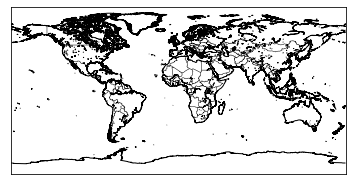

In [14]:
# Draw coast line
# Reference: https://plot.ly/~Dreamshot/9152

# Make shortcut to Basemap object, 
# not specifying projection type for this example
from mpl_toolkits.basemap import Basemap
m = Basemap(resolution='i') 

# Functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    # init. plotting list
    lons=[]
    lats=[]

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
    
        
        lats.extend(lat_cc.tolist()+[None]) 
        lons.extend(lon_cc.tolist()+[None])
        
    return lons, lats

# Function generating coastline lon/lat 
def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    cc_lons, cc_lats= polygons_to_traces(poly_paths, N_poly)
    return cc_lons, cc_lats

# Function generating country lon/lat 
def get_country_traces():
    poly_paths = m.drawcountries().get_paths() # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    country_lons, country_lats= polygons_to_traces(poly_paths, N_poly)
    return country_lons, country_lats
  
# Get list of of coastline, country, and state lon/lat 
cc_lons, cc_lats=get_coastline_traces()
country_lons, country_lats=get_country_traces()

#concatenate the lon/lat for coastlines and country boundaries:
lons=cc_lons+[None]+country_lons
lats=cc_lats+[None]+country_lats

xs_bd, ys_bd, zs_bd = mapping_map_to_sphere(lons, lats, radius=1.01)# here the radius is slightly greater than 1 
                                                         #to ensure lines visibility; otherwise (with radius=1)
                                                         # some lines are hidden by contours colors
        
boundaries=dict(type='scatter3d',
               x=xs_bd,
               y=ys_bd,
               z=zs_bd,
               mode='lines',
               line=dict(color='gray', width=4)
              )

<h2 style='color:#b56576'>1. Earthquake Distribution Plot (Depth)

In [15]:
depmax = 700.
depmin = 0.
depbin = 50.

cmin = depmin
cmax = depmax
cbin = depbin

seis_3D_depth_up = go.Scatter3d(x = xs_ev_up,
                      y = ys_ev_up,
                      z = zs_ev_up,
                      mode='markers',
                      name='measured',
                      marker = dict(
                          size = 1.*evMag,
                          cmax = cmax,
                          cmin = cmin,
                          colorbar = dict(
                              title = 'Source Depth',
                              titleside = 'right',
                              titlefont = dict(size = 16, 
                                               color = titlecolor, 
                                               family='Courier New'),
                              tickmode = 'array',
                              ticks = 'outside',
                              ticktext = list(np.arange(cmin,cmax+cbin,cbin)),
                              tickvals = list(np.arange(cmin,cmax+cbin,cbin)),
                              tickcolor = titlecolor,
                              tickfont = dict(size=14, color = titlecolor,
                                             family='Courier New')
                          ),
                          ### choose color option
                          color = evDepth,
                          ### choose color option
                          colorscale = Cscale_EQ,
                          showscale = True,
                          opacity=1.),
                      hoverinfo='skip'
                      )


plot_data = dict(data=[topo_sphere_3d ,seis_3D_depth_up], layout=layout)
fig = go.Figure(data = plot_data)
fig.update_layout(title_text='3D Earthquake Distribution Map',)

plot(fig, validate=True, filename='3DEarthquakeDistribution.html', auto_open=True)

'3DEarthquakeDistribution.html'

<h2 style='color:#b56576'>2. Earthquake Distribution Plot (Time)

In [16]:
# Plot events in 3D with color of years since 2020
cmin = 0
cmax = 20
cbin = 1
seis_3D_time_up = go.Scatter3d(x = xs_ev_up,
                      y = ys_ev_up,
                      z = zs_ev_up,
                      mode='markers',
                      name='measured',
                      marker = dict(
                          size = 1.*evMag,
                          cmax = cmax,
                          cmin = cmin,
                          colorbar = dict(
                              title = 'Years since 2000',
                              titleside = 'right',
                              titlefont = dict(size = 16, 
                                               color = titlecolor,
                                               family='Courier New'),
                              tickmode = 'array',
                              ticks = 'outside',
                              ticktext = list(np.arange(cmin,cmax+cbin,cbin)),
                              tickvals = list(np.arange(cmin,cmax+cbin,cbin)),
                              tickcolor = titlecolor,
                              tickfont = dict(size=14, color = titlecolor,
                                             family='Courier New')
                          ),
                          ### choose color option
                          color = Timefrom_RefYears,
                          ### choose color option
                          colorscale = Cscale_EQ,
                          showscale = True,
                          opacity=1.),
                      hoverinfo='skip'
                      )

plot_data = dict(data = [topo_sphere_3d , seis_3D_time_up], layout = layout)
fig = go.Figure(data = plot_data, layout =layout)
fig.update_layout(title_text='3D Earthquake Distribution Map',)

plot(fig, validate=True, filename='3DEarthquakeDistribution2.html', auto_open=True)

'3DEarthquakeDistribution2.html'

In [17]:
ratio_k = 0.85
xs_k = xs * ratio_k
ys_k = ys * ratio_k
zs_k = zs * ratio_k

black_sphere=dict(type='surface',
    x=xs_k,
    y=ys_k,
    z=zs_k,
    colorscale=['black', 'black', 'black'],
    surfacecolor=zs_k,
    opacity=1.,
    showscale=False,
    hoverinfo='skip'
    )

<h2 style='color:#b56576'>3. Earthquake Distribution Plot (Boundary)

In [18]:
seis_3D_depth = go.Scatter3d(x = xs_ev,
                      y = ys_ev,
                      z = zs_ev,
                      mode='markers',
                      name='measured',
                      marker = dict(
                          size = 1.*evMag,
                          cmax = cmax,
                          cmin = cmin,
                          colorbar = dict(
                              title = 'Source Depth',
                              titleside = 'right',
                              titlefont = dict(size = 16, 
                                               color = titlecolor,
                                               family='Courier New'),
                              tickmode = 'array',
                              ticks = 'outside',
                              ticktext = list(np.arange(cmin,cmax+cbin,cbin)),
                              tickvals = list(np.arange(cmin,cmax+cbin,cbin)),
                              tickcolor = titlecolor,
                              tickfont = dict(size=14, color = titlecolor,
                                             family='Courier New')
                          ),
                          ### choose color option
                          color = evDepth,
                          ### choose color option
                          colorscale = Cscale_EQ,
                          showscale = True,
                          opacity=1.),
                      hoverinfo='skip'
                      )

plot_data = dict(data=[boundaries, black_sphere, seis_3D_depth], layout=layout)
fig = go.Figure(data = plot_data)
fig.update_layout(title_text='3D Earthquake Distribution Map')

plot(fig, validate=False, filename='3DEarthquakeDistribution3.html', auto_open=True)

'3DEarthquakeDistribution3.html'